### Preprocessing

In [1]:
import pandas as pd

In [2]:
df = pd.read_table('data/pdbbind/index/INDEX_general_PL_data.2020',skiprows=4,sep=r'\s+',usecols=[0,4]).drop(0)
df = df.rename(columns={'#': 'name','release': 'affinity'})
df_refined = pd.read_table('data/pdbbind/index/INDEX_refined_data.2020',skiprows=4,sep=r'\s+',usecols=[0,4]).drop(0)
df_refined = df_refined.rename(columns={'#': 'name','release': 'affinity'})
df = pd.concat([df,df_refined])

In [3]:
quantities = ['ki','kd','ka','k1/2','kb','ic50','ec50']

In [4]:
from pint import UnitRegistry
ureg = UnitRegistry()

def to_uM(affinity):
    val = ureg(affinity)
    try:
        return val.m_as(ureg.uM)
    except Exception:
        pass
    
    try:
        return 1/val.m_as(1/ureg.uM)
    except Exception:
        pass

In [5]:
df['affinity_uM'] = df['affinity'].str.split('[=\~><]').str[1].apply(to_uM)
df['affinity_quantity'] = df['affinity'].str.split('[=\~><]').str[0]

<AxesSubplot:>

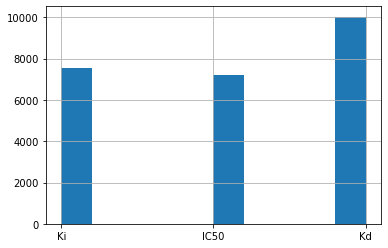

In [6]:
df['affinity_quantity'].hist()

In [7]:
df_filter = df[df['affinity_quantity'].str.lower().isin(quantities)]
df_filter = df_filter.dropna()

In [8]:
cutoffs = [5,8,11,15]

In [9]:
dfs_complex = {c: pd.read_parquet('data/pdbbind_complex_{}.parquet'.format(c)) for c in cutoffs}

In [10]:
import dask.array as da
import dask.dataframe as dd
from dask.bag import from_delayed
from dask import delayed
import pyarrow as pa
import pyarrow.parquet as pq

In [11]:
contacts_dask = [da.from_npy_stack('data/pdbbind_contacts_{}'.format(c)) for c in cutoffs]
shape = contacts_dask[0][0].shape
print(shape)

(2046, 510)


In [12]:
contacts_dask[0].blocks[1]

dask.array<blocks, shape=(700, 2046, 510), dtype=float32, chunksize=(700, 2046, 510), chunktype=numpy.ndarray>

In [13]:
[len(c) for c in contacts_dask]

[16232, 16228, 16226, 16223]

In [14]:
contacts_dask[0].shape[0]

16232

In [15]:
import numpy as np
all_partitions = []
for c, cutoff in zip(contacts_dask,cutoffs):
    def chunk_to_sparse(rcut, chunk, idx_chunk):
        res = dfs_complex[rcut].iloc[idx_chunk][['name']].copy()
        # pad to account for [CLS] and [SEP]
        res['contacts_{}A'.format(rcut)] = [np.where(np.pad(a,pad_width=(1,1)).flatten())[0] for a in chunk]
        return res

    partitions = [delayed(chunk_to_sparse)(cutoff,b,k)
                  for b,k in zip(c.blocks, da.arange(c.shape[0],chunks=c.chunks[0:1]).blocks)
                 ]
    all_partitions.append(partitions)

In [16]:
all_partitions[0][0].compute().head()

name                                        contacts_5A
0  10gs  [3083, 3084, 3086, 3087, 3088, 3089, 3094, 309...
1  184l  [39945, 39946, 39947, 39948, 43010, 43012, 430...
2  186l  [39943, 39944, 39945, 43010, 43011, 43012, 430...
3  187l  [39937, 39938, 39947, 43009, 43010, 43012, 430...
4  188l  [39937, 39938, 39940, 39941, 43009, 43010, 430...

In [17]:
ddfs = [dd.from_delayed(p) for p in all_partitions]

In [18]:
ddf_all = None
for d in ddfs:
    if ddf_all is not None:
        ddf_all = ddf_all.merge(d, on='name')
    else:
        ddf_all = d
ddf_all = ddf_all.merge(df_filter,on='name')
ddf_all = ddf_all.merge(list(dfs_complex.values())[0],on='name')

In [19]:
%%time
df_all_contacts = ddf_all.compute()

CPU times: user 8min 53s, sys: 11min 31s, total: 20min 24s
Wall time: 3min 29s


In [20]:
df_all_contacts['neg_log10_affinity_M'] = 6-np.log10(df_all_contacts['affinity_uM'])

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_all_contacts['affinity'] = scaler.fit_transform(df_all_contacts['neg_log10_affinity_M'].values.reshape(-1,1))
scaler.mean_, scaler.var_

(array([6.34387834]), array([3.57815698]))

In [22]:
# save to parquet
df_all_contacts.drop(columns=['name','affinity_quantity']).astype({'affinity': 'float32','neg_log10_affinity_M': 'float32'}).to_parquet('data/pdbbind_with_contacts.parquet',index=False)